In [0]:
# libraries
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold,StratifiedKFold
from sklearn.metrics import roc_auc_score
import torch
from torch.utils.data import TensorDataset, DataLoader,Dataset
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import time 
import tqdm
import random
from PIL import Image
train_on_gpu = True
from torch.utils.data.sampler import SubsetRandomSampler
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau, CosineAnnealingLR

import cv2

try:
    import albumentations
    from albumentations import torch as AT
except:
    ! pip install albumentations
    import albumentations
    from albumentations import torch as AT
#import pretrainedmodels

import scipy
import scipy.special

try:
    from pytorchcv.model_provider import get_model as ptcv_get_model
except:
    ! pip install pytorchcv
    from pytorchcv.model_provider import get_model as ptcv_get_model
    
cudnn.benchmark = True


     |████████████████████████████████| 327kB 3.4MB/s 


In [0]:
#####################
SEED = 152
#####################
def seed_everything(seed=SEED):
    random.seed(seed)
    os.environ['PYHTONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    

seed_everything(SEED)
#base_dir = '../input/histopathologic-cancer-detection/'
MODEL_NAME = "bagnet33"
#TEST_FRAC = 0.10
#SELECT_FOLD = 6
Final_Linear_Layer = 15


TRAIN_OR_PREDICT = "train"
#TRAIN_OR_PREDICT = "predict"
NUM_TTA = 4

if TRAIN_OR_PREDICT == "predict":
    SAVED_WEIGHT = '../input/dense1/dense1_model_val9861.pt'

#### InceptionV4 299 ####


In [0]:
if MODEL_NAME == "cbam_resnet50":
    New_size = 224
    ! wget https://github.com/osmr/imgclsmob/releases/download/v0.0.125/cbam_resnet50-0605-a1172fe6.pth.zip
    ! unzip cbam_resnet50-0605-a1172fe6.pth.zip

    model_conv = ptcv_get_model(MODEL_NAME, pretrained=False)
    model_conv.load_state_dict(torch.load("cbam_resnet50-0605-a1172fe6.pth"))
    #model_conv = ptcv_get_model("bam_resnet50", pretrained=True)

    #model_conv = pretrainedmodels.se_resnext101_32x4d()
    #model_conv.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
    model_conv.output = nn.Sequential(nn.Dropout(0.6), nn.Linear(in_features=2048, out_features=512, bias=True), nn.SELU(),
                                      nn.Dropout(0.8),  nn.Linear(in_features=512, out_features=Final_Linear_Layer, bias=True))
    
elif MODEL_NAME == "densenet121":
    New_size = 224
    ! wget https://github.com/osmr/imgclsmob/releases/download/v0.0.3/densenet121-0803-f994107a.pth.zip
    ! unzip densenet121-0803-f994107a.pth.zip
    
    model_conv = ptcv_get_model(MODEL_NAME, pretrained=False)
    model_conv.load_state_dict(torch.load("densenet121-0803-f994107a.pth"))
    
    model_conv.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
    model_conv.last_linear = nn.Sequential(nn.Dropout(0.6), nn.Linear(in_features=2048, out_features=512, bias=True), nn.SELU(),
                                      nn.Dropout(0.8),  nn.Linear(in_features=512, out_features=Final_Linear_Layer, bias=True))

elif MODEL_NAME == "nasnet_6a4032":
    New_size = 331
    ! wget https://github.com/osmr/imgclsmob/releases/download/v0.0.101/nasnet_6a4032-0421-f354d28f.pth.zip
    ! unzip nasnet_6a4032-0421-f354d28f.pth.zip
    
    model_conv = ptcv_get_model(MODEL_NAME, pretrained=False)
    model_conv.load_state_dict(torch.load("nasnet_6a4032-0421-f354d28f.pth"))
    
    model_conv.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
    model_conv.last_linear = nn.Sequential(nn.Dropout(0.6), nn.Linear(in_features=2048, out_features=512, bias=True), nn.SELU(),
                                      nn.Dropout(0.8),  nn.Linear(in_features=512, out_features=Final_Linear_Layer, bias=True))

elif MODEL_NAME == "InceptionV4":
    New_size = 299
    ! wget https://github.com/osmr/imgclsmob/releases/download/v0.0.105/inceptionv4-0529-5cb7b4e4.pth.zip
    ! unzip inceptionv4-0529-5cb7b4e4.pth.zip
    
    model_conv = ptcv_get_model(MODEL_NAME, pretrained=False)
    model_conv.load_state_dict(torch.load("inceptionv4-0529-5cb7b4e4.pth"))
    
    model_conv.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
    model_conv.last_linear = nn.Sequential(nn.Dropout(0.6), nn.Linear(in_features=2048, out_features=512, bias=True), nn.SELU(),
                                      nn.Dropout(0.8),  nn.Linear(in_features=512, out_features=Final_Linear_Layer, bias=True))

elif MODEL_NAME == "resnet34":
    New_size = 224
    ! wget https://github.com/osmr/imgclsmob/releases/download/v0.0.1/resnet34-0818-6f947d40.pth.zip
    ! unzip resnet34-0818-6f947d40.pth.zip
    model_conv = ptcv_get_model(MODEL_NAME, pretrained=False)
    model_conv.load_state_dict(torch.load("resnet34-0818-6f947d40.pth"))
    
    model_conv.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
    model_conv.last_linear = nn.Sequential(nn.Dropout(0.6), nn.Linear(in_features=2048, out_features=512, bias=True), nn.SELU(),
                                      nn.Dropout(0.8),  nn.Linear(in_features=512, out_features=Final_Linear_Layer, bias=True))
    
elif MODEL_NAME == "resnet50":
    New_size = 224
    #! wget https://github.com/osmr/imgclsmob/releases/download/v0.0.147/resnet50-0658-828686d7.pth.zip
    #! unzip resnet50-0658-828686d7.pth.zip
    model_conv = ptcv_get_model(MODEL_NAME, pretrained=True)
    #model_conv.load_state_dict(torch.load("resnet50-0658-828686d7.pth"))
    
    #model_conv.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
    #model_conv.last_linear = nn.Sequential(nn.Dropout(0.6), nn.Linear(in_features=2048, out_features=512, bias=True), nn.SELU(),
    #                                  nn.Dropout(0.8),  nn.Linear(in_features=512, out_features=Final_Linear_Layer, bias=True))
    
elif MODEL_NAME == "seresnet50":
    New_size = 224
    ! wget https://github.com/osmr/imgclsmob/releases/download/v0.0.11/seresnet50-0640-8820f2af.pth.zip
    ! unzip seresnet50-0640-8820f2af.pth.zip
    model_conv = ptcv_get_model(MODEL_NAME, pretrained=False)
    model_conv.load_state_dict(torch.load("seresnet50-0640-8820f2af.pth"))
    
    #model_conv.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
    model_conv.output = nn.Sequential(nn.Dropout(0.6), nn.Linear(in_features=2048, out_features=512, bias=True), nn.SELU(),
                                      nn.Dropout(0.8), nn.Linear(in_features=512, out_features=Final_Linear_Layer, bias=True))
    
elif MODEL_NAME == "bagnet33":
    New_size = 224
    try:
        import bagnets.pytorch
    except:
        ! pip install git+https://github.com/wielandbrendel/bag-of-local-features-models.git
        import bagnets.pytorch
    #! wget https://bitbucket.org/wielandbrendel/bag-of-feature-pretrained-models/raw/249e8fa82c0913623a807d9d35eeab9da7dcc2a8/bagnet32-2ddd53ed.pth.tar
    model_conv = bagnets.pytorch.bagnet33(pretrained=True)
    #model_conv.load_state_dict(torch.load("bagnet32-2ddd53ed.pth.tar"))
    
    #model_conv.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
    #model_conv.fc = nn.Sequential(nn.Dropout(0.6), nn.Linear(in_features=2048, out_features=512, bias=True), nn.SELU(),
    #                                  nn.Dropout(0.8),  nn.Linear(in_features=512, out_features=Final_Linear_Layer, bias=True))
    model_conv.fc = nn.Linear(in_features=2048, out_features=Final_Linear_Layer, bias=True)
    
elif MODEL_NAME == "bagnet17":
    New_size = 224
    try:
        import bagnets.pytorch
    except:
        ! pip install git+https://github.com/wielandbrendel/bag-of-local-features-models.git
        import bagnets.pytorch
    #! wget https://bitbucket.org/wielandbrendel/bag-of-feature-pretrained-models/raw/249e8fa82c0913623a807d9d35eeab9da7dcc2a8/bagnet16-105524de.pth.tar
    model_conv = bagnets.pytorch.bagnet17(pretrained=True)
    #model_conv.load_state_dict(torch.load("bagnet16-105524de.pth.tar"))
    
    model_conv.fc = nn.Linear(in_features=2048, out_features=Final_Linear_Layer, bias=True)
    
elif MODEL_NAME == "bagnet9":
    New_size = 224
    try:
        import bagnets.pytorch
    except:
        ! pip install git+https://github.com/wielandbrendel/bag-of-local-features-models.git
        import bagnets.pytorch
    #! wget https://bitbucket.org/wielandbrendel/bag-of-feature-pretrained-models/raw/249e8fa82c0913623a807d9d35eeab9da7dcc2a8/bagnet16-105524de.pth.tar
    model_conv = bagnets.pytorch.bagnet9(pretrained=True)
    #model_conv.load_state_dict(torch.load("bagnet16-105524de.pth.tar"))
    
    model_conv.fc = nn.Linear(in_features=2048, out_features=Final_Linear_Layer, bias=True)
    
else:
    print("wrong model name")
    exit(1)

  Cloning https://github.com/wielandbrendel/bag-of-local-features-models.git to /tmp/pip-req-build-55d_td0e
  Running command git clone -q https://github.com/wielandbrendel/bag-of-local-features-models.git /tmp/pip-req-build-55d_td0e
  Stored in directory: /tmp/pip-ephem-wheel-cache-zzac5sau/wheels/0a/19/2d/8d12301f794d89faacba978e5dccfabde920ecd6b150eec755
Successfully built bagnets


Downloading: "https://bitbucket.org/wielandbrendel/bag-of-feature-pretrained-models/raw/249e8fa82c0913623a807d9d35eeab9da7dcc2a8/bagnet32-2ddd53ed.pth.tar" to /root/.cache/torch/checkpoints/bagnet32-2ddd53ed.pth.tar
100%|██████████| 73491720/73491720 [00:02<00:00, 29709841.31it/s]


In [0]:
def BlackMaskPatch(img, square_size, flag):
    ################ ADD BLACK MASK
    # Input :
    #       Img : Input Image (height,width,channel)
    #       squareSize : size of single square mask
    #       flag: 0 for average distribution masks
    #             1 for only top left mask
    #             2 for only bottom left mask
    #             3 for only top right mask
    #             4 for only bottom right mask

    m,n,c = img.shape

    mask = np.ones((m,n,c)).astype(np.uint8)*255
    colNum = m//square_size
    if ((colNum)%2 ==0) :
        edgeSize = (m%square_size + square_size)//2
        colNum  = colNum -1
    else:
        edgeSize = (m % square_size)//2

    if flag ==0:
        for i in range (colNum):
            for j in range (colNum):
                if i%2==0 and (i+j)%2==0:
                    mask[edgeSize+square_size*i:edgeSize+square_size*(i+1),edgeSize+square_size*j:edgeSize+square_size*(j+1),:]= 0
    if flag == 1:
        mask[edgeSize:edgeSize+square_size,edgeSize:edgeSize+square_size,:]=0

    if flag == 2:
        mask[edgeSize+square_size*(colNum-1):edgeSize+square_size*colNum,edgeSize:edgeSize+square_size,:]=0

    if flag == 3:
        mask[edgeSize :edgeSize + square_size , edgeSize+square_size*(colNum - 1):edgeSize + square_size* colNum, :] = 0

    if flag == 4:
        mask[edgeSize+square_size*(colNum-1):edgeSize+square_size*colNum,edgeSize+square_size*(colNum-1):edgeSize+square_size*colNum,:]=0
        
    new_img = cv2.bitwise_and(img.astype(np.uint8), mask)

    return new_img

def Image_Scrambling(img,cropNum):
    ################ ADD BLACK MASK
    # Input :
    #       Img : Input Image (height,width,channel)
    #       cropNum: The image will be split into cropNum*cropNum pieces and scrambling

    height,width,channel = img.shape
    item_width = int(width / cropNum)
    box_list = []

    for i in range(cropNum):
        for j in range(cropNum):
            box = img[i*item_width:(i+1)*item_width,j*item_width:(j+1)*item_width]
            box_list.append(box)

    random.shuffle(box_list)

    new_img = np.zeros((height,width,channel)).astype(np.uint8)
    for i in range(cropNum):
        for j in range(cropNum):
            new_img[i*item_width:(i+1)*item_width,j*item_width:(j+1)*item_width] = box_list[i*cropNum+j]
    return new_img



In [0]:
data_transforms_train = albumentations.Compose([
    albumentations.Resize(New_size, New_size),
    albumentations.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225]),
    AT.ToTensor()
    ])

data_transforms_train2 = transforms.Compose([
    transforms.Resize((New_size, New_size)),
    transforms.ToTensor(),  # convert to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225]),
])


In [0]:
!rm -rf DLdata/
!rm -rf ./training/
!rm -rf ./validation/
!rm -rf ./test1/
!rm -rf ./__MACOSX/validation/._.DS_Store
!rm -rf ./__MACOSX/test1/._.DS_Store
!git clone https://github.com/SifanSong/DLdata.git
!unzip ./DLdata/training.zip
!unzip ./DLdata/validation.zip
!unzip ./DLdata/test1.zip

Cloning into 'DLdata'...
remote: Enumerating objects: 17, done.
remote: Counting objects: 100% (17/17), done.
remote: Compressing objects: 100% (15/15), done.
remote: Total 17 (delta 1), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (17/17), done.
Archive:  ./DLdata/training.zip
   creating: training/
   creating: training/Forest/
  inflating: training/Forest/image_0152.jpg  
  inflating: training/Forest/image_0190.jpg  
  inflating: training/Forest/image_0184.jpg  
  inflating: training/Forest/image_0192.jpg  
  inflating: training/Forest/image_0227.jpg  
  inflating: training/Forest/image_0233.jpg  
  inflating: training/Forest/image_0031.jpg  
  inflating: training/Forest/image_0193.jpg  
  inflating: training/Forest/image_0144.jpg  
  inflating: training/Forest/image_0140.jpg  
  inflating: training/Forest/image_0020.jpg  
  inflating: training/Forest/image_0034.jpg  
  inflating: training/Forest/image_0237.jpg  
  inflating: training/Forest/image_0182.jpg  
  inflating

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Dataset ImageFolder
    Number of datapoints: 1200
    Root Location: ./training/
    Transforms (if any): Compose(
                             Resize(size=(224, 224), interpolation=PIL.Image.BILINEAR)
                             Lambda()
                             ToTensor()
                             Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                         )
    Target Transforms (if any): None
Dataset ImageFolder
    Number of datapoints: 300
    Root Location: ./validation/
    Transforms (if any): Compose(
                             Resize(size=(224, 224), interpolation=PIL.Image.BILINEAR)
                             Lambda()
                             ToTensor()
                             Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                         )
    Target Transforms (if any): None
Dataset ImageFolder
    Number of datapoints: 1200
    Root Location: ./test1/
    Transforms (if any): Compose(
        

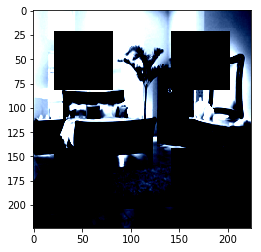

In [0]:
## import CV3 datasets
training_data = torchvision.datasets.ImageFolder('./training/', transform=data_transforms_train2)
val_data = torchvision.datasets.ImageFolder('./validation/', transform=data_transforms_train2)
test_data = torchvision.datasets.ImageFolder('./test1/', transform=data_transforms_train2)
## return are tuples (sample, target)
## https://pytorch.org/docs/stable/torchvision/datasets.html#imagefolder
## https://github.com/williamFalcon/pytorch-imagenet-dataset
print(training_data)
print(val_data)
print(test_data)

new_training_label = ()
new_training_data = ()
print(training_data[0][0].shape)
training_img = training_data[0][0].permute(1,2,0).numpy()
plt.imshow(training_img)
plt.show()


In [0]:
train_loader = torch.utils.data.DataLoader(
    training_data,
    batch_size=4,
    shuffle=True,
    num_workers=0
)

val_loader = torch.utils.data.DataLoader(
    val_data,
    batch_size=4,
    shuffle=False,
    num_workers=0
)

test_loader = torch.utils.data.DataLoader(
    test_data,
    batch_size=4,
    shuffle=False,
    num_workers=0
)

In [0]:
model_conv.cuda()
#criterion = nn.BCEWithLogitsLoss()
criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model_conv.parameters(), lr=4e-5)

scheduler = StepLR(optimizer, 5, gamma=0.2)
scheduler.step()



In [0]:
list(model_conv.children())

[Conv2d(3, 64, kernel_size=(1, 1), stride=(1, 1), bias=False),
 Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), bias=False),
 BatchNorm2d(64, eps=1e-05, momentum=0.001, affine=True, track_running_stats=True),
 ReLU(inplace),
 Sequential(
   (0): Bottleneck(
     (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
     (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), bias=False)
     (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
     (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU(inplace)
     (downsample): Sequential(
       (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(2, 2), bias=False)
       (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     )
 

In [0]:
try:
    from torchsummary import summary
except:
    !pip install torchsummary
    from torchsummary import summary

summary(model_conv, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]             192
            Conv2d-2         [-1, 64, 222, 222]          36,864
       BatchNorm2d-3         [-1, 64, 222, 222]             128
              ReLU-4         [-1, 64, 222, 222]               0
            Conv2d-5         [-1, 64, 222, 222]           4,096
       BatchNorm2d-6         [-1, 64, 222, 222]             128
              ReLU-7         [-1, 64, 222, 222]               0
            Conv2d-8         [-1, 64, 110, 110]          36,864
       BatchNorm2d-9         [-1, 64, 110, 110]             128
             ReLU-10         [-1, 64, 110, 110]               0
           Conv2d-11        [-1, 256, 110, 110]          16,384
      BatchNorm2d-12        [-1, 256, 110, 110]             512
           Conv2d-13        [-1, 256, 111, 111]          16,384
      BatchNorm2d-14        [-1, 256, 1

In [0]:
#try:
#    from google.colab import files
#    uploaded = files.upload()
#except:
#    print("Not running on colab. Ignoring.")

In [0]:
#!ls
#model_conv.load_state_dict(torch.load('model_val9466.pt'))

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [0]:
try: 
    import torchbearer
except:
    !pip install torchbearer
    import torchbearer
from torchbearer import Trial
from torch import optim

start_epoch = 0
TOTAL_EPOCH = 40
INITIAL_LR = 4e-5

train_loss = []
train_acc = []
val_loss = []
val_acc = []
test_acc = []
test_loss = []

device = "cuda:0" if torch.cuda.is_available() else "cpu"

optimizer = optim.Adam(model_conv.parameters(), lr=INITIAL_LR)

tolerate = 0
best_val_acc = 0
patiance = 0

for i in range(start_epoch, TOTAL_EPOCH):
  print("Training starts: Epoch ", i)
  
  trial = Trial(model_conv, optimizer, criterion, metrics=['loss', 'accuracy']).to(device)
  trial.with_generators(train_loader, val_generator=val_loader, test_generator=test_loader)
  trial.run(epochs=1)
  
  results_training = trial.evaluate(data_key=torchbearer.TRAIN_DATA)
  train_loss.append(results_training['train_loss'])
  train_acc.append(results_training['train_acc'])
  
  results = trial.evaluate(data_key=torchbearer.VALIDATION_DATA)
  val_loss.append(results['val_loss'])
  val_acc.append(results['val_acc'])
  
  results_test = trial.evaluate(data_key=torchbearer.TEST_DATA)
  test_loss.append(results_test['test_loss'])
  test_acc.append(results_test['test_acc'])
  
  if results['val_acc'] >= best_val_acc:
    best_val_acc = results['val_acc']
    torch.save(model_conv.state_dict(), 'model_val%d.pt'%(best_val_acc*10000))
    print(" --------- New best validation acc --------- ", best_val_acc)
    
    patiance = 0
    
  else:
    tolerate += 1
    patiance += 1
    print("tolerate: ", tolerate, ", patiance: ", patiance)
  
  if tolerate >= 3:
    INITIAL_LR /= 2
    optimizer = optim.Adam(model_conv.parameters(), lr=INITIAL_LR)
    tolerate = 0
    print("New LR: ", INITIAL_LR)
    
  if patiance > 15:
    break
    print("Early stopping")
    
    
  

Training starts: Epoch  0


KeyboardInterrupt: ignored

In [0]:
print('model_val%d.pt'%(best_val_acc*10000))
model_conv.load_state_dict(torch.load('model_val%d.pt'%(best_val_acc*10000)))

results = trial.evaluate(data_key=torchbearer.VALIDATION_DATA)
print(results)

model_val9466.pt


{'val_loss': 0.20918437838554382, 'val_acc': 0.9466667175292969}


In [0]:
## investigate the performance on the test data
predictions = trial.predict()
predicted_classes = predictions.argmax(1).cpu()
true_classes = [x for (_,x) in test_data.samples]
Index = ["Bedroom", "Coast", "Forest", "Highway", "Industrial", "InsideCity", "Kitchen", 
        "LivingRoom", "Mountain", "Office", "OpenCountry", "Store", "Street", "Suburb", "TallBuilding"]

from sklearn import metrics
CLASS = training_data.classes
print(metrics.classification_report(true_classes, predicted_classes, target_names=CLASS))

              precision    recall  f1-score   support

     Bedroom       0.84      0.82      0.83        80
       Coast       0.93      0.93      0.93        80
      Forest       0.96      0.95      0.96        80
     Highway       0.96      0.94      0.95        80
  Industrial       0.99      0.95      0.97        80
  InsideCity       0.94      0.95      0.94        80
     Kitchen       0.95      0.89      0.92        80
  LivingRoom       0.87      0.81      0.84        80
    Mountain       0.90      0.94      0.92        80
      Office       0.91      1.00      0.95        80
 OpenCountry       0.86      0.91      0.88        80
       Store       0.92      0.96      0.94        80
      Street       0.97      0.93      0.95        80
      Suburb       1.00      1.00      1.00        80
TallBuilding       0.96      0.96      0.96        80

   micro avg       0.93      0.93      0.93      1200
   macro avg       0.93      0.93      0.93      1200
weighted avg       0.93   

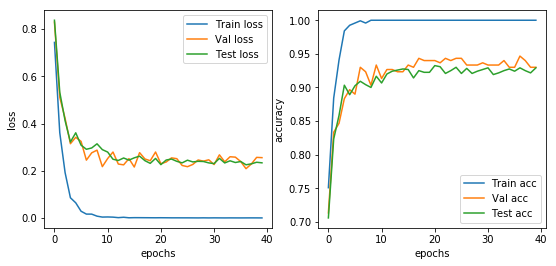

In [0]:
fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(9,4))
ax[0].plot(train_loss, label= "Train loss")
ax[0].plot(val_loss, label= "Val loss")
ax[0].plot(test_loss, label= "Test loss")
ax[0].set_xlabel("epochs")
ax[0].set_ylabel("loss")
ax[0].legend()
ax[1].plot(train_acc, label= "Train acc")
ax[1].plot(val_acc, label= "Val acc")
ax[1].plot(test_acc, label= "Test acc")
ax[1].set_xlabel("epochs")
ax[1].set_ylabel("accuracy")
ax[1].legend()

In [0]:
out=open('model_val%d.txt'%(best_val_acc*10000), 'w')

out.write(str(train_loss) + "\n")
out.write(str(val_loss) + "\n")
out.write(str(test_loss) + "\n")
out.write(str(train_acc) + "\n")
out.write(str(val_acc) + "\n")
out.write(str(test_acc) + "\n")

out.close()

In [0]:
!head model_val9466.txt
from google.colab import files
files.download('model_val%d.txt'%(best_val_acc*10000))

[0.7437601685523987, 0.36127158999443054, 0.19261594116687775, 0.08602508157491684, 0.06465337425470352, 0.02902202680706978, 0.016907282173633575, 0.016778433695435524, 0.008172956295311451, 0.004272374790161848, 0.004794206935912371, 0.0040286327712237835, 0.001895591034553945, 0.003515015821903944, 0.0012935952981933951, 0.0018269118154421449, 0.001755870645865798, 0.001619883463717997, 0.0014512046473100781, 0.0013216444058343768, 0.0015056399861350656, 0.001335205277428031, 0.001128865871578455, 0.0011222767643630505, 0.0010606794385239482, 0.0010232897475361824, 0.0009439055575057864, 0.0007698865956626832, 0.001067784265615046, 0.0007783719338476658, 0.0010182746918871999, 0.0008733785361982882, 0.0007429302204400301, 0.0008980735437944531, 0.0008133705705404282, 0.0007367714424617589, 0.0008402864332310855, 0.0009118815651163459, 0.0008633188554085791, 0.0007329718209803104]
[0.8293845057487488, 0.5110535621643066, 0.4220815896987915, 0.3148961663246155, 0.34193357825279236, 0.

In [0]:
files.download('model_val%d.pt'%(best_val_acc*10000))

In [0]:
from skimage import feature, transform

def plot_heatmap2(heatmap, original, ax, cmap='RdBu_r', 
                 percentile=99, dilation=0.5, alpha=0.25):
    """
    Plots the heatmap on top of the original image 
    (which is shown by most important edges).
    
    Parameters
    ----------
    heatmap : Numpy Array of shape [X, X]
        Heatmap to visualise.
    original : Numpy array of shape [X, X, 3]
        Original image for which the heatmap was computed.
    ax : Matplotlib axis
        Axis onto which the heatmap should be plotted.
    cmap : Matplotlib color map
        Color map for the visualisation of the heatmaps (default: RdBu_r)
    percentile : float between 0 and 100 (default: 99)
        Extreme values outside of the percentile range are clipped.
        This avoids that a single outlier dominates the whole heatmap.
    dilation : float
        Resizing of the original image. Influences the edge detector and
        thus the image overlay.
    alpha : float in [0, 1]
        Opacity of the overlay image.
    
    """
    if len(heatmap.shape) == 3:
        heatmap = np.mean(heatmap, 0)
    
    dx, dy = 0.05, 0.05
    xx = np.arange(0.0, heatmap.shape[1], dx)
    yy = np.arange(0.0, heatmap.shape[0], dy)
    xmin, xmax, ymin, ymax = np.amin(xx), np.amax(xx), np.amin(yy), np.amax(yy)
    extent = xmin, xmax, ymin, ymax
    cmap_original = plt.get_cmap('Greys_r')
    cmap_original.set_bad(alpha=0)
    overlay = None
    if original is not None:
        # Compute edges (to overlay to heatmaps later)
        original_greyscale = original if len(original.shape) == 2 else np.mean(original, axis=-1)
        in_image_upscaled = transform.rescale(original_greyscale, dilation, mode='constant', 
                                              multichannel=False, anti_aliasing=True)
        edges = feature.canny(in_image_upscaled).astype(float)
        edges[edges < 0.5] = np.nan
        edges[:5, :] = np.nan
        edges[-5:, :] = np.nan
        edges[:, :5] = np.nan
        edges[:, -5:] = np.nan
        overlay = edges
    
    abs_max = np.percentile(heatmap, percentile)
    abs_min = np.percentile(heatmap, 100 - percentile)
    
    ax.imshow(heatmap, extent=extent, interpolation='none', cmap=cmap, vmin=abs_min, vmax=abs_max)
    if overlay is not None:
        ax.imshow(overlay, extent=extent, interpolation='none', cmap=cmap_original, alpha=alpha)
        

def generate_heatmap_pytorch2(model, image, target, patchsize, maptype = "None"):
    """
    Generates high-resolution heatmap for a BagNet by decomposing the
    image into all possible patches and by computing the logits for
    each patch.
    
    Parameters
    ----------
    model : Pytorch Model
        This should be one of the BagNets.
    image : Numpy array of shape [1, 3, X, X]
        The image for which we want to compute the heatmap.
    target : int
        Class for which the heatmap is computed.
    patchsize : int
        The size of the receptive field of the given BagNet.
    """
    import torch
    
    with torch.no_grad():
        # pad with zeros
        _, c, x, y = image.shape
        padded_image = np.zeros((c, x + patchsize - 1, y + patchsize - 1))
        padded_image[:, (patchsize-1)//2:(patchsize-1)//2 + x, (patchsize-1)//2:(patchsize-1)//2 + y] = image[0]
        image = padded_image[None].astype(np.float32)
        
        # turn to torch tensor
        input = torch.from_numpy(image).cuda()
        
        # extract patches
        patches = input.permute(0, 2, 3, 1) 
        #print("patches.shape before unfold: ", patches.shape) # [1, 256, 256, 3]
        patches = patches.unfold(1, patchsize, 1).unfold(2, patchsize, 1)
        #print("patches.shape after unfold: ", patches.shape) # [1, 224, 224, 3, 33, 33]
        num_rows = patches.shape[1] # 224
        num_cols = patches.shape[2] # 224
        patches = patches.contiguous().view((-1, 3, patchsize, patchsize))
        #print("patches.shape after view: ", patches.shape) # [50176, 3, 33, 33]

        # compute logits for each patch
        logits_list = []

        for batch_patches in torch.split(patches, 1000):
            # print(batch_patches.shape) # [1000, 3, 33, 33]
            logits = model(batch_patches)
            # print(logits.shape) # [1000, 15]
            logits = logits[:, target] #[:, 0]
            # print(logits.shape) # [1000]
            logits_list.append(logits.data.cpu().numpy().copy())

        logits = np.hstack(logits_list)
        ## adding by myself centralisation
        if maptype == "cent":
            logits = (logits - logits.mean()) / logits.std() 
        final_logits = logits.reshape((224, 224))
        final_logits = final_logits[(patchsize-1)//2:224-(patchsize-1)//2, (patchsize-1)//2:224-(patchsize-1)//2]
        #print(final_logits[:30, :])
        return final_logits

def select_image_and_headmap2(original = test_data[24][0], label = test_data[24][1], maptype = 'None'):

    original = original
    label = label
    # preprocess sample image
    sample = original / 255.
    sample = sample.numpy()
    sample -= np.array([0.485, 0.456, 0.406])[:, None, None]
    sample /= np.array([0.229, 0.224, 0.225])[:, None, None]
    sample = torch.Tensor(sample).unsqueeze(0)
    
    # generate heatmap
    heatmap = generate_heatmap_pytorch2(model_conv, sample, label, 33, maptype)
    
    # plot heatmap
    fig = plt.figure(figsize=(8, 4))
    original2 = original.numpy()
    original_image = original2.transpose([1,2,0])
    
    ax = plt.subplot(121)
    ax.set_title('original')
    plt.imshow(original_image[16:224-16,16:224-16,0] / 255., interpolation='nearest', cmap = plt.cm.Greys_r)
    plt.axis('off')
    
    ax = plt.subplot(122)
    ax.set_title('heatmap')
    plot_heatmap2(heatmap, original_image, ax, dilation=0.5, percentile=99, alpha=.25)
    plt.axis('off')
    
    plt.show()
    
def predict_labels(SAMPLE):
  select_image_and_headmap2(original = test_data[SAMPLE][0], label = int(predicted_classes[SAMPLE]), maptype = 'cent')
  if test_data[SAMPLE][1] != int(predicted_classes[SAMPLE]):
    select_image_and_headmap2(original = test_data[SAMPLE][0], label = test_data[SAMPLE][1], maptype = 'cent')
  print("Prediction: ", Index[int(predicted_classes[SAMPLE])], ", True class: ", Index[test_data[SAMPLE][1]])

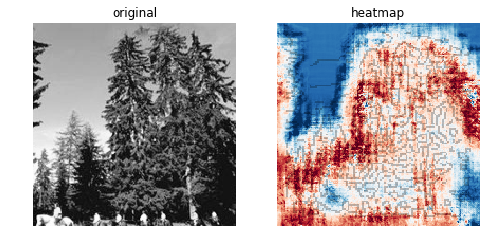

Prediction:  Forest , True class:  Forest


In [0]:
predict_labels(180)

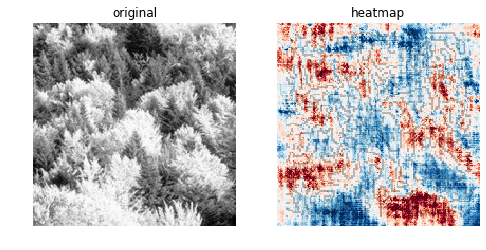

Prediction:  Forest , True class:  Forest


In [0]:
predict_labels(184)

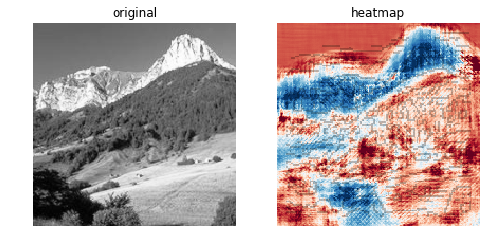

Prediction:  Mountain , True class:  Mountain


In [0]:
predict_labels(650)

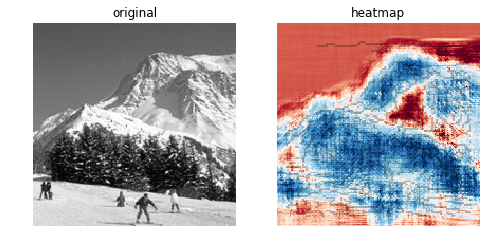

Prediction:  Mountain , True class:  Mountain


In [0]:
predict_labels(651)

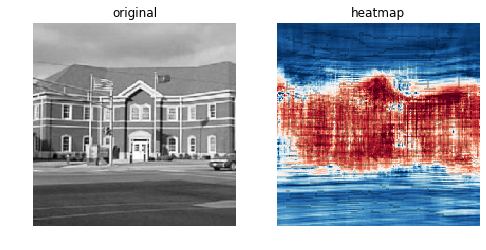

Prediction:  InsideCity , True class:  InsideCity


In [0]:
predict_labels(410)

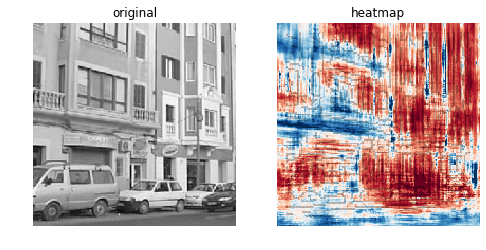

Prediction:  InsideCity , True class:  InsideCity


In [0]:
predict_labels(411)

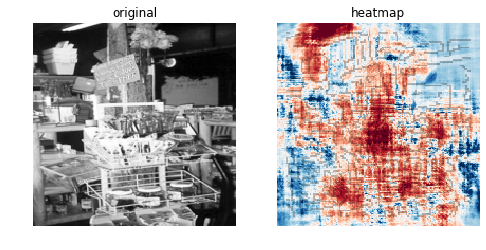

Prediction:  Store , True class:  Store


In [0]:
predict_labels(884)

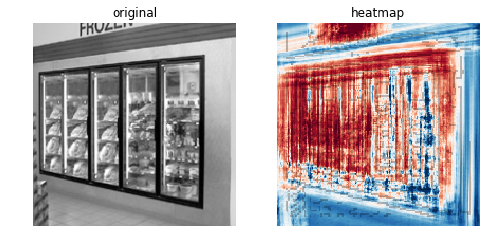

Prediction:  Store , True class:  Store


In [0]:
predict_labels(885)

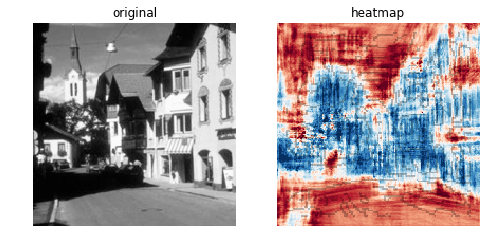

Prediction:  Street , True class:  Street


In [0]:
predict_labels(962)

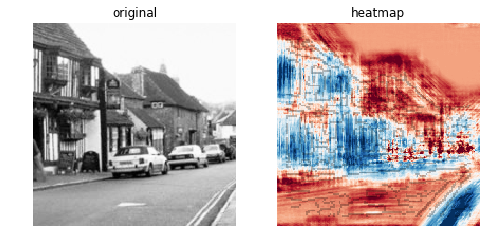

Prediction:  Street , True class:  Street


In [0]:
predict_labels(963)

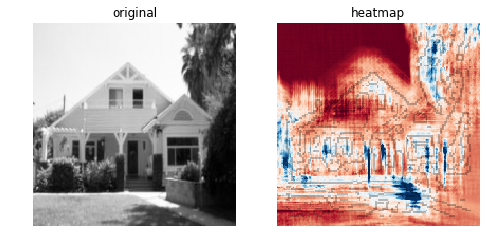

Prediction:  Suburb , True class:  Suburb


In [0]:
predict_labels(1052)

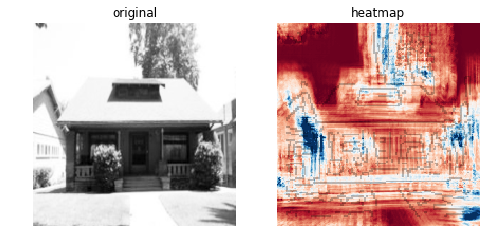

Prediction:  Suburb , True class:  Suburb


In [0]:
predict_labels(1051)

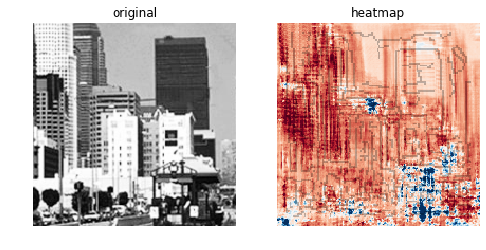

Prediction:  TallBuilding , True class:  TallBuilding


In [0]:
predict_labels(1165)

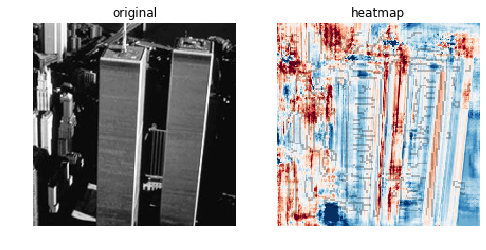

Prediction:  TallBuilding , True class:  TallBuilding


In [0]:
predict_labels(1166)

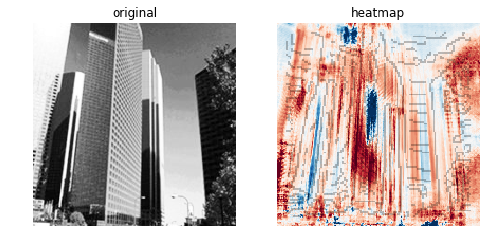

Prediction:  TallBuilding , True class:  TallBuilding


In [0]:
predict_labels(1167)

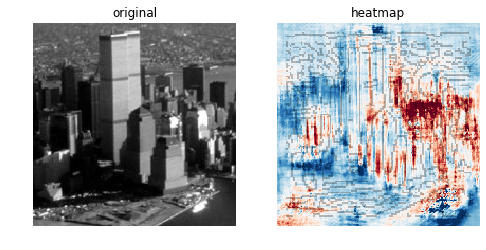

Prediction:  TallBuilding , True class:  TallBuilding


In [0]:
predict_labels(1168)

In [0]:
#!rm bagnet32-2ddd53ed.pth.tar.*
!ls

#!rm model_val*

bagnet32-2ddd53ed.pth.tar  model_val7766.pt  model_val9333.pt  test1
DLdata			   model_val8266.pt  model_val9366.pt  training
__MACOSX		   model_val8300.pt  sample_data       validation


In [0]:
#try:
#    from google.colab import files
#    uploaded = files.upload()
#except:
#    print("Not running on colab. Ignoring.")

bagnet32-2ddd53ed.pth.tar  model_val7766.pt  model_val9333.pt  test1
DLdata			   model_val8266.pt  model_val9366.pt  training
__MACOSX		   model_val8300.pt  sample_data       validation
